## Observations and Insights 

In [ ]:
#You must use proper labeling of your plots, to include properties such as: plot titles, axis labels, legend labels, 
#_x_-axis and _y_-axis limits, etc.

#See the [starter workbook](Pymaceuticals/pymaceuticals_starter.ipynb) for help on what modules to import and 
#expected format of the notebook.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from itertools import cycle, islice
#import seaborn as sns

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
study_results = study_results.rename(columns={"Drug Regimen":"Drug_Regimen", "Tumor Volume (mm3)":"Tumor_Volume_mm3", "Mouse ID":"Mouse_ID"})
mouse_metadata = mouse_metadata.rename(columns={"Drug Regimen":"Drug_Regimen", "Mouse ID":"Mouse_ID"})

mouse_study_df = pd.merge(mouse_metadata, study_results)

mouse_study_df

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [2]:
# Checking the number of mice.
a = mouse_metadata["Mouse_ID"].nunique()
b = study_results["Mouse_ID"].nunique()
c = mouse_study_df["Mouse_ID"].nunique()
a, b, c

(249, 249, 249)

In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
#https://stackoverflow.com/questions/29276958/identifying-duplicate-pairs-in-python-pandas
find_dup = mouse_study_df.groupby(['Mouse_ID', 'Timepoint']).size()                                 
find_dup = find_dup[find_dup > 1]
find_dup

Mouse_ID  Timepoint
g989      0            2
          5            2
          10           2
          15           2
          20           2
dtype: int64

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
# One copy of g989 seems to have died...
dup = mouse_study_df.loc[mouse_study_df['Mouse_ID'] == "g989"]
dup

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_study_clean_df = mouse_study_df[mouse_study_df["Mouse_ID"] != "g989"]
mouse_study_clean_df

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [6]:
# Checking the number of mice in the clean DataFrame.
mouse_study_clean_df["Mouse_ID"].nunique()

248

In [8]:
#Put placebo results first

#This seems harder than it should be, but none of the easier-looking suggestions I found did more than put the \
#treatments in alphabetical order.
#https://stackoverflow.com/questions/43266211/sort-a-dataframe-based-on-values-of-another-column-using-integer-data-type                                                     
#https://stackoverflow.com/questions/23279238/custom-sorting-with-pandas

drugs = mouse_study_clean_df.Drug_Regimen.unique()
#drugs
order = {'Placebo':0,'Ramicane':1, 'Capomulin':2, 'Infubinol':3,  'Ceftamin':4, 'Stelasyn':5, 'Zoniferol':6, 'Ketapril':7, 'Propriva':8, 'Naftisol':9}
mouse_study_clean_df.loc[:,'rank'] = mouse_study_clean_df.loc[:,'Drug_Regimen'].map(order)
mouse_study_clean_df = mouse_study_clean_df.iloc[mouse_study_clean_df['rank'].argsort()]
mouse_study_clean_df = mouse_study_clean_df.drop(labels=['rank'],axis=1)
mouse_study_clean_df

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
952,i477,Placebo,Female,3,30,10,47.520632,0
1832,y478,Placebo,Female,3,25,40,65.971120,1
1831,y478,Placebo,Female,3,25,35,61.888027,1
1830,y478,Placebo,Female,3,25,30,59.374615,1
1295,o795,Placebo,Female,20,26,0,45.000000,0
...,...,...,...,...,...,...,...,...
1005,j755,Naftisol,Male,23,27,5,47.242844,0
1878,z795,Naftisol,Female,13,29,25,57.947100,2
1877,z795,Naftisol,Female,13,29,20,53.280657,1
1209,n304,Naftisol,Male,9,26,15,48.477979,0


## Summary Statistics

In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method is the most straighforward, creating multiple series and putting them all together at the end.
mice_by_drugs = mouse_study_clean_df.groupby("Drug_Regimen")
#drugs = mouse_study_clean_df.Drug_Regimen.unique()
#mice_by_drugs
mean = mice_by_drugs["Tumor_Volume_mm3"].mean()
median = mice_by_drugs["Tumor_Volume_mm3"].median()
variance = mice_by_drugs["Tumor_Volume_mm3"].var()
std = mice_by_drugs["Tumor_Volume_mm3"].std()
sem = mice_by_drugs["Tumor_Volume_mm3"].sem()

mouse_study_stats_df = pd.merge(mean, median, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3_x":"mean", "Tumor_Volume_mm3_y":"median"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, variance, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3":"variance"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, std, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3":"std"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, sem, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3":"sem"})

#Put placebo results first
order = pd.Categorical(['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'], ordered=True)
mouse_study_stats_df = mouse_study_stats_df.reindex(order)
mouse_study_stats_df

,mean,median,variance,std,sem
Drug_Regimen,,,,,
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332


In [10]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function
#https://stackoverflow.com/questions/55388610/how-to-calculate-aggregated-summary-statistics-in-pandas-dataframe

summary_table = mouse_study_clean_df.groupby(["Drug_Regimen"]).agg({"Tumor_Volume_mm3":['mean', 'median', 'var', 'std', 'sem']})
#Put placebo results first
order = pd.Categorical(['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'], ordered=True)
summary_table = summary_table.reindex(order)
summary_table

Tumor_Volume_mm3                                          
                         mean     median        var       std       sem
Drug_Regimen                                                           
Placebo             54.033581  52.288934  61.168083  7.821003  0.581331
Ramicane            40.216745  40.673236  23.486704  4.846308  0.320955
Capomulin           40.675741  41.557809  24.947764  4.994774  0.329346
Infubinol           52.884795  51.820584  43.128684  6.567243  0.492236
Ceftamin            52.591172  51.776157  39.290177  6.268188  0.469821
Stelasyn            54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol           53.236507  51.818479  48.533355  6.966589  0.516398
Ketapril            55.235638  53.698743  68.553577  8.279709  0.603860
Propriva            52.320930  50.446266  43.852013  6.622085  0.544332
Naftisol            54.331565  52.509285  66.173479  8.134708  0.596466

## Bar and Pie Charts

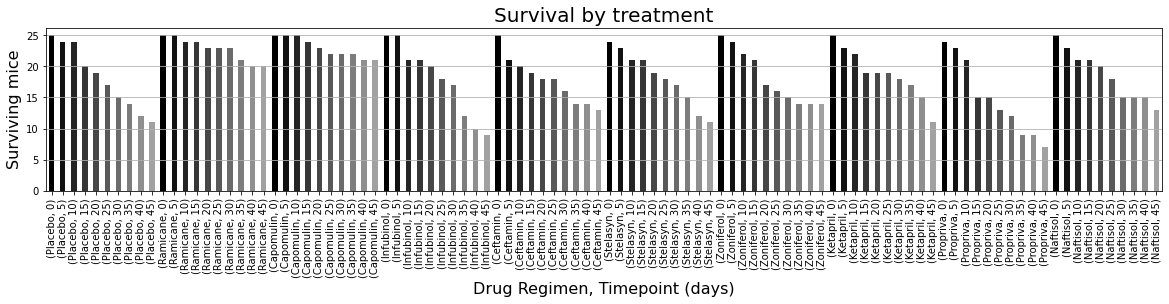

In [11]:
#Generate a bar plot using `DataFrame.plot()` that shows  the number of 
#total mice for each treatment regimen throughout the course of the study.

#In real life I would probably go to Illustrator to make a more user-friendly x-axis.

#https://stackoverflow.com/questions/39275294/sort-by-certain-order-situation-pandas-dataframe-groupby

#Put placebo results first
ordered_drugs = ['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol']
order = pd.api.types.CategoricalDtype(categories=ordered_drugs, ordered=True)
mouse_study_clean_df['Drug_Regimen'] = mouse_study_clean_df['Drug_Regimen'].astype(order)

drug_group = mouse_study_clean_df.groupby(['Drug_Regimen', 'Timepoint'])

count_mice = drug_group['Mouse_ID'].count()

my_colors = list(islice(cycle(['0', '.07', '0.14', '0.21', '0.28', '0.35', '0.42', '0.49', '0.56', '0.63']), None, len(drug_group)))

ax=count_mice.plot(kind="bar", figsize=(20,3), legend=False, title="Survival by treatment", color=my_colors)

ax.set_ylabel("Surviving mice", size=16)
ax.set_xlabel("Drug Regimen, Timepoint (days)", size=16)
ax.set_title("Survival by treatment", size=20)
ax.grid(axis='y')

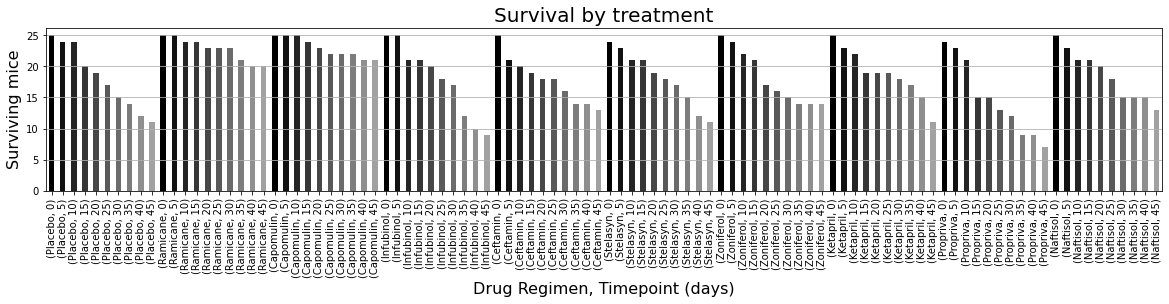

In [12]:
#Generate a bar plot using Matplotlib's `pyplot`.

#In real life I would probably go to Illustrator to make a more user-friendly x-axis.

#Put placebo results first
ordered_drugs = ['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol']
order = pd.api.types.CategoricalDtype(categories=ordered_drugs, ordered=True)
mouse_study_clean_df.loc['Drug_Regimen'] = mouse_study_clean_df['Drug_Regimen'].astype(order)

drug_group = mouse_study_clean_df.groupby(['Drug_Regimen', 'Timepoint'])

count_mice = drug_group['Mouse_ID'].count()

colors = '0', '.07', '0.14', '0.21', '0.28', '0.35', '0.42', '0.49', '0.56', '0.63'

count_chart = count_mice.plot(kind='bar', color=colors, figsize=(20,3))
plt.title("Survival by treatment", size=20)
plt.ylabel("Surviving mice", size=16)
plt.xlabel("Drug Regimen, Timepoint (days)", size=16)
plt.grid(axis='y')
plt.show()

Text(0.5, 1.0, 'Mice by sex')

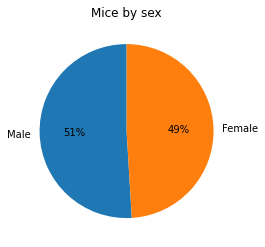

In [13]:
#Generate a pie plot using Pandas's `DataFrame.plot()` that shows the distribution of female or male mice in the study.

ax=mouse_study_clean_df['Sex'].value_counts().plot.pie(startangle=90, autopct='%1.0f%%', label='')
ax.set_title("Mice by sex")



<function matplotlib.pyplot.show(*args, **kw)>

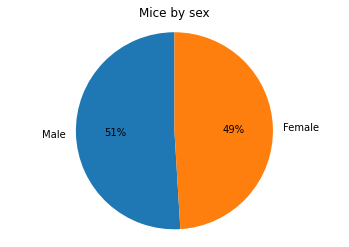

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot


labels="Male", "Female"
plt.pie(mouse_study_clean_df['Sex'].value_counts(), labels=labels, autopct='%1.0f%%', startangle=90)
plt.title("Mice by sex")
plt.axis('equal')
plt.show



## Quartiles, Outliers and Boxplots

drugs = list(mouse_study_stats_df.axes[0].tolist())
time_points = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
mouse_IDs = list(mouse_study_clean_df.axes[1].tolist())
mouse_IDs = mouse_study_clean_df.('Mouse ID').unique()
mouse_IDs

In [48]:
#Calculate the final tumor volume of each mouse across four of the most promising treatment regimens: Capomulin, 
 #   Ramicane, Infubinol, and Ceftamin. 

final_timepoints = mouse_study_clean_df.groupby(['Drug_Regimen','Mouse_ID'])['Timepoint'].max()
final_timepoint_indices=final_timepoints.aggregate(lambda x: [x.tolist()], axis=0)

#Had to cut and paste the numbers, couldn't figure out how to make pandas read it...
rows= [309, 299, 64, 244, 360, 440, 204, 337, 317, 380, 282, 39, 144, 1455, 134, 390, 19, 370, 164, 104, 350, 340, 224, 29, 124, 493, 594, 600, 617, 840, 940, 993, 1033, 1112, 1119, 1122, 1132, 1162, 1260, 1379, 1406, 1551, 1582, 1583, 1670, 1743, 1773, 1797, 1845, 1855, 463, 473, 530, 540, 637, 669, 742, 800, 834, 949, 1053, 1076, 1205, 1225, 1312, 1314, 1397, 1485, 1616, 1632, 1640, 1683, 1726, 1813, 1872, 513, 696, 725, 735, 764, 824, 851, 864, 884, 930, 938, 1043, 1102, 1193, 1203, 1246, 1277, 1334, 1354, 1390, 1593, 1605, 1627, 1703, 1823, 567, 610, 774, 790, 810, 856, 1013, 1142, 1152, 1169, 1215, 1294, 1465, 1475, 1571, 1599, 1614, 1645, 1752, 1753, 1803, 1835, 1857, 1882, 1892, 483, 577, 657, 706, 716, 784, 952, 968, 983, 1163, 1237, 1267, 1304, 1424, 1444, 1479, 1498, 1501, 1561, 1576, 1619, 1648, 1678, 1787, 1833, 550, 751, 893, 903, 962, 1063, 1099, 1216, 1218, 1228, 1280, 1290, 1360, 1451, 1492, 1508, 1540, 1598, 1658, 1693, 1736, 1739, 1742, 1862, 327, 430, 214, 174, 289, 154, 272, 400, 49, 184, 254, 94, 194, 9, 74, 114, 420, 262, 234, 447, 59, 410, 449, 453, 84, 500, 523, 587, 627, 679, 822, 907, 937, 978, 1023, 1058, 1086, 1179, 1315, 1369, 1387, 1528, 1530, 1550, 1636, 1709, 1734, 1763, 1859, 510, 557, 593, 647, 667, 689, 752, 755, 814, 836, 850, 874, 1003, 1068, 1096, 1183, 1250, 1325, 1344, 1416, 1434, 1518, 1660, 1719, 1777]
collection = mouse_study_clean_df.loc[rows]

#collection.set_index("Drug_Regimen")
#print(collection)

best_drugs_final_timepoints_df = collection[collection["Drug_Regimen"].isin(['Capomulin','Ramicane','Infubinol','Ceftamin'])]
#best_drugs_final_timepoints_df = collection[collection["Drug_Regimen"] != ['Placebo','Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol']]

print(best_drugs_final_timepoints_df)

best_drugs_final_timepoints_df.loc[:, 'Tumor_Volume_mm3']=best_drugs_final_timepoints_df['Tumor_Volume_mm3'].astype('float')
best_drugs_final_timepoints_df.loc[:, 'Weight (g)']=best_drugs_final_timepoints_df['Weight (g)'].astype('float')
best_drugs_final_timepoints_df.loc[:, 'Timepoint']=best_drugs_final_timepoints_df['Timepoint'].astype('float')
best_drugs_final_timepoints_df.loc[:, 'Age_months']=best_drugs_final_timepoints_df['Age_months'].astype('float')
best_drugs_final_timepoints_df.loc[:, 'Metastatic Sites']=best_drugs_final_timepoints_df['Metastatic Sites'].astype('float')
best_drugs_final_timepoints_df
#best_drugs_final_timepoints_df.dtypes

    Mouse_ID Drug_Regimen     Sex Age_months Weight (g) Timepoint  \
309     b128    Capomulin  Female          9         22        45   
299     b742    Capomulin    Male          7         21        45   
64      f966    Capomulin    Male         16         17        20   
244     g288    Capomulin    Male          3         19        45   
360     g316    Capomulin  Female         22         22        45   
..       ...          ...     ...        ...        ...       ...   
59      s508     Ramicane    Male          1         17        45   
410     u196     Ramicane    Male         18         25        45   
449     w678     Ramicane  Female          5         24         5   
453     y449     Ramicane    Male         19         24        15   
84      z578     Ramicane    Male         11         16        45   

    Tumor_Volume_mm3 Metastatic Sites  
309          38.9829                2  
299          38.9396                0  
64            30.486                0  
244        

/Users/bmacgreg/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
309,b128,Capomulin,Female,9.0,22.0,45.0,38.982878,2.0
299,b742,Capomulin,Male,7.0,21.0,45.0,38.939633,0.0
64,f966,Capomulin,Male,16.0,17.0,20.0,30.485985,0.0
244,g288,Capomulin,Male,3.0,19.0,45.0,37.074024,1.0
360,g316,Capomulin,Female,22.0,22.0,45.0,40.159220,2.0
...,...,...,...,...,...,...,...,...
59,s508,Ramicane,Male,1.0,17.0,45.0,30.276232,0.0
410,u196,Ramicane,Male,18.0,25.0,45.0,40.667713,3.0
449,w678,Ramicane,Female,5.0,24.0,5.0,43.166373,0.0
453,y449,Ramicane,Male,19.0,24.0,15.0,44.183451,0.0


In [53]:
#Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.
#best_drugs_final_timepoints_df = best_drugs_final_timepoints_df[best_drugs_final_timepoints_df["Drug_Regimen"].isin(['Capomulin','Ramicane','Infubinol','Ceftamin'])]

Lower_quartile = best_drugs_final_timepoints_df.groupby("Drug_Regimen")['Tumor_Volume_mm3'].quantile([.25])
Median = best_drugs_final_timepoints_df.groupby("Drug_Regimen")['Tumor_Volume_mm3'].quantile([.5])
Upper_quartile = best_drugs_final_timepoints_df.groupby("Drug_Regimen")['Tumor_Volume_mm3'].quantile([.75])

quartiles_df=pd.merge(Lower_quartile, Median, on="Drug_Regimen")
quartiles_df = quartiles_df.rename(columns = {"Tumor_Volume_mm3_x":"Lower_quartile", "Tumor_Volume_mm3_y":"Median"})
quartiles_df=pd.merge(quartiles_df, Upper_quartile, on="Drug_Regimen")
quartiles_df = quartiles_df.rename(columns = {"Tumor_Volume_mm3":"Upper_quartile"})

quartiles_df["IQR"] = quartiles_df["Upper_quartile"] - quartiles_df["Lower_quartile"]

quartiles_df["Lower_bound"] = quartiles_df["Lower_quartile"] - (1.5*quartiles_df["IQR"])
quartiles_df["Upper_bound"] = quartiles_df["Upper_quartile"] + (1.5*quartiles_df["IQR"])

quartiles_df["Min_volume"] = best_drugs_final_timepoints_df.groupby("Drug_Regimen")['Tumor_Volume_mm3'].min()
quartiles_df["Max_volume"] = best_drugs_final_timepoints_df.groupby("Drug_Regimen")['Tumor_Volume_mm3'].max()

quartiles_df


,Lower_quartile,Median,Upper_quartile,IQR,Lower_bound,Upper_bound,Min_volume,Max_volume
Drug_Regimen,,,,,,,,
Placebo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ramicane,31.560470,36.561652,40.659006,9.098537,17.912664,54.306811,22.050126,45.220869
Capomulin,32.377357,38.125164,40.159220,7.781863,20.704562,51.832015,23.343598,47.685963
Infubinol,54.048608,60.165180,65.525743,11.477135,36.832905,82.741446,36.321346,72.226731
Ceftamin,48.722078,59.851956,64.299830,15.577752,25.355450,87.666458,45.000000,68.923185
Stelasyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zoniferol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ketapril,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Propriva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


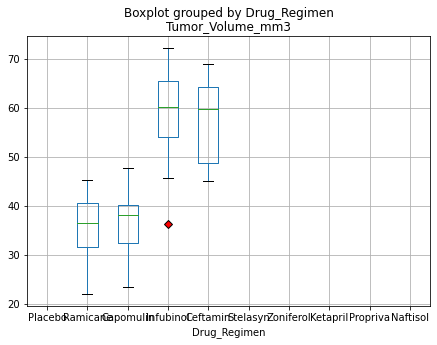

In [30]:
#Using Matplotlib, generate a box and whisker plot of the final tumor volume for all four treatment regimens 
#and highlight any potential outliers in the plot by changing their color and style.
  
# I guess this is pandas, not Matplotlib, but it's based on Matplotlib and is so much easier... although harder to format titles.   
    
#Hint**: All four box plots should be within the same figure. Use this [Matplotlib documentation page]
#(https://matplotlib.org/gallery/pyplots/boxplot_demo_pyplot.html#sphx-glr-gallery-pyplots-boxplot-demo-pyplot-py) 
#for help with changing the style of the outliers.
#tumor_size_boxplot = best_drugs_final_timepoints_df.boxplot(column="Tumor Volume (mm3)")
best_drugs_final_timepoints_df = best_drugs_final_timepoints_df[best_drugs_final_timepoints_df["Drug_Regimen"].isin(['Capomulin','Ramicane','Infubinol','Ceftamin'])]
red_diamond = dict(markerfacecolor='r', marker='D')

#tumor_size_boxplot = best_drugs_final_timepoints_df.boxplot(column="Tumor_Volume_mm3", by="Drug_Regimen", sym="D", figsize=(7, 5))

tumor_size_boxplot = best_drugs_final_timepoints_df.boxplot(column="Tumor_Volume_mm3", by="Drug_Regimen", flierprops=red_diamond, figsize=(7, 5))

#plt.title("Final Tumor Volume (mm^3) by Drug Regimen")
#ax.set_ylabel('Tumor volume (mm^3)')
#best_drugs_final_timepoints_df.boxplot(column="Tumor Volume (mm3)", by="Drug_Regimen", ax=None, fontsize=None, rot=0, grid=True, figsize=None, layout=None, return_type=None, **kwds)
#tumor_size_boxplot(best_drugs_final_timepoints_df["Tumor_Volume_mm3"], flierprops=green_diamond)

#ax=best_drugs_final_timepoints_df.plot(kind="boxplot", figsize=(7,5), legend=False, title="Final Tumor Volume (mm^3) by Drug Regimen")


#d2 = np.concatenate((spread, center, flier_high, flier_low))
#data.shape = (-1, 1)
#d2.shape = (-1, 1)
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
#data = [data, d2, d2[::2, 0]]

# Multiple box plots on one Axes
#fig, ax = plt.subplots()
#ax.boxplot(data)

#plt.show()



#ax.set_ylabel("Surviving mice", size=16)
#ax.set_xlabel("Drug Regimen, Timepoint (days)", size=16)
#ax.set_title("Survival by treatment", size=20)
#ax.grid(axis='y')


## Line and Scatter Plots

In [ ]:
#Select a mouse that was treated with Capomulin and generate a line plot of tumor volume vs. timepoint for that mouse.
#best_drugs_final_timepoints_df = collection[collection["Drug_Regimen"].isin(['Capomulin','Ramicane','Infubinol','Ceftamin'])]

Mouse_b128_df = mouse_study_clean_df[mouse_study_clean_df['Mouse_ID'].str.match('b128')]

plot = plt.plot(Mouse_b128_df["Timepoint"], Mouse_b128_df["Tumor_Volume_mm3"])
plt.xlabel('Timepoint (day)', size=12)
plt.ylabel('Tumor volume (mm^3)', size=12)
plt.suptitle('Capomulin treatment: Mouse B128')
plt.show()

In [ ]:
#Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin treatment regimen.
Capomulin_df = mouse_study_clean_df[mouse_study_clean_df['Drug_Regimen'].str.match('Capomulin')]
#Capomulin_df

Capomulin_by_mouse = Capomulin_df.groupby("Mouse_ID")
mean_tumor_volume = Capomulin_by_mouse["Tumor_Volume_mm3"].mean()
mean_mouse_weight = Capomulin_by_mouse["Weight (g)"].mean()

Capomulin_tumor_vol_mouse_weight = pd.merge(mean_mouse_weight, mean_tumor_volume, on=["Mouse_ID"])
#Capomulin_tumor_vol_mouse_weight
#mice_by_drugs = mouse_study_clean_df.groupby("Drug_Regimen")
#mean = mice_by_drugs["Tumor_Volume_mm3"].mean()
#mouse_study_stats_df = pd.merge(mean, median, on=["Drug_Regimen"])
#mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3_x":"mean", "Tumor_Volume_mm3_y":"median"})
plot = plt.scatter(Capomulin_tumor_vol_mouse_weight["Weight (g)"], Capomulin_tumor_vol_mouse_weight["Tumor_Volume_mm3"])
plt.xlabel('Average weight (g)', size=12)
plt.ylabel('Average tumor volume (mm^3)', size=12)
plt.suptitle('Capomulin treatment: Average tumor volume vs. Average mouse weight')
plt.show()

In [ ]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
plot = plt.scatter(Capomulin_tumor_vol_mouse_weight["Tumor_Volume_mm3"], Capomulin_tumor_vol_mouse_weight["Weight (g)"])
plt.ylabel('Average weight (g)', size=12)
plt.xlabel('Average tumor volume (mm^3)', size=12)
plt.suptitle('Capomulin treatment: Average mouse weight vs. Average tumor volume')
plt.show()

## Correlation and Regression

In [ ]:
#Calculate the correlation coefficient and linear regression model between mouse weight and average tumor volume 
#for the Capomulin treatment. Plot the linear regression model on top of the previous scatter plot.


In [ ]:
#Look across all previously generated figures and tables and write at least three observations or inferences 
#that can be made from the data. Include these observations at the top of notebook.